<a href="https://colab.research.google.com/github/SrinijaB-05/SafeStreet-1/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')

class RoadImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Custom Dataset for Road Images

        Args:
            image_paths (list): List of full paths to images
            labels (list): Corresponding binary labels (0: not road, 1: road)
            transform (callable, optional): Optional image transformations
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

def prepare_dataset(dataset_path):
    """
    Prepare dataset by collecting image paths and labels

    Args:
        dataset_path (str): Path to dataset folder

    Returns:
        tuple: Training and validation datasets
    """
    # Collect image paths and labels
    road_images = [os.path.join(dataset_path, 'road', f) for f in os.listdir(os.path.join(dataset_path, 'road')) if f.endswith(('.jpg', '.png', '.jpeg'))]
    non_road_images = [os.path.join(dataset_path, 'non_road', f) for f in os.listdir(os.path.join(dataset_path, 'non_road')) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Create labels
    road_labels = [1] * len(road_images)
    non_road_labels = [0] * len(non_road_images)

    # Combine images and labels
    all_images = road_images + non_road_images
    all_labels = road_labels + non_road_labels

    # Split dataset
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )

    # Create datasets
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = RoadImageDataset(train_images, train_labels, transform=train_transform)
    val_dataset = RoadImageDataset(val_images, val_labels, transform=val_transform)

    return train_dataset, val_dataset

def train_model(train_dataset, val_dataset, num_epochs=10, batch_size=32):
    """
    Train Vision Transformer for road image classification

    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training

    Returns:
        torch.nn.Module: Trained model
    """
    # Prepare dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Load pre-trained Vision Transformer and modify the classifier
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

    # Replace the classifier head for binary classification
    model.classifier = nn.Linear(model.classifier.in_features, 2)

    # Prepare device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {100*correct/total:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {100*val_correct/val_total:.2f}%')

    return model

def main():
    # Update this path to your Google Drive dataset location
    dataset_path = '/content/drive/MyDrive/road_classification_dataset'

    # Prepare datasets
    train_dataset, val_dataset = prepare_dataset(dataset_path)

    # Train model
    model = train_model(train_dataset, val_dataset)

    # Save model
    torch.save(model.state_dict(), '/content/drive/MyDrive/road_image_classifier.pth')
    print("Model saved successfully!")

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
Train Loss: 0.4706, Train Accuracy: 72.32%
Val Loss: 0.1011, Val Accuracy: 100.00%
Epoch 2/10
Train Loss: 0.0310, Train Accuracy: 100.00%
Val Loss: 0.0294, Val Accuracy: 100.00%
Epoch 3/10
Train Loss: 0.0101, Train Accuracy: 100.00%
Val Loss: 0.0161, Val Accuracy: 100.00%
Epoch 4/10
Train Loss: 0.0031, Train Accuracy: 100.00%
Val Loss: 0.0118, Val Accuracy: 100.00%
Epoch 5/10
Train Loss: 0.0014, Train Accuracy: 100.00%
Val Loss: 0.0090, Val Accuracy: 100.00%
Epoch 6/10
Train Loss: 0.0009, Train Accuracy: 100.00%
Val Loss: 0.0073, Val Accuracy: 100.00%
Epoch 7/10
Train Loss: 0.0005, Train Accuracy: 100.00%
Val Loss: 0.0061, Val Accuracy: 100.00%
Epoch 8/10
Train Loss: 0.0005, Train Accuracy: 100.00%
Val Loss: 0.0054, Val Accuracy: 100.00%
Epoch 9/10
Train Loss: 0.0003, Train Accuracy: 100.00%
Val Loss: 0.0048, Val Accuracy: 100.00%
Epoch 10/10
Train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


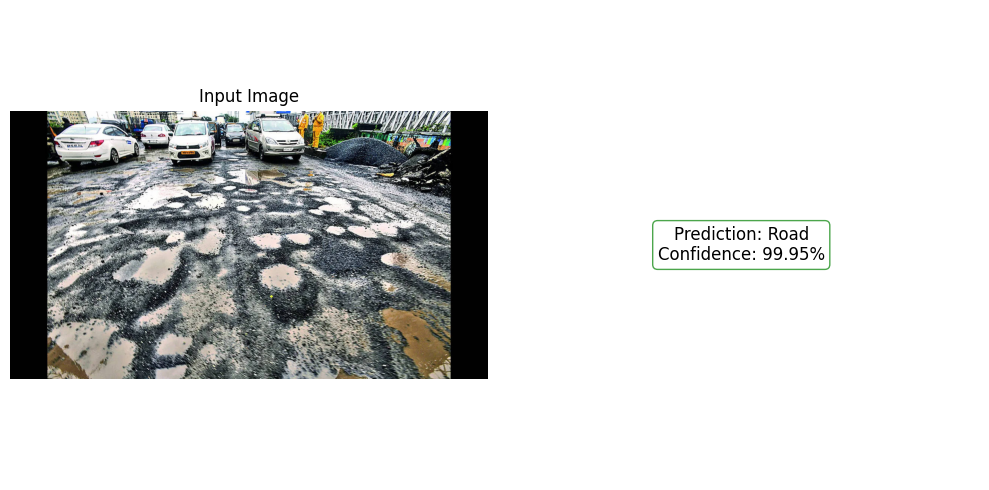

Prediction: Road
Confidence: 99.95%


In [22]:
import torch
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from PIL import Image
import torchvision.transforms as transforms

class RoadImageClassifier:
    def __init__(self, model_path):
        """
        Initialize the road image classifier

        Args:
            model_path (str): Path to the saved model weights
        """
        # Load the pre-trained model architecture
        self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

        # Modify classifier head for binary classification
        self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 2)

        # Load the saved model weights
        self.model.load_state_dict(torch.load(model_path))

        # Set model to evaluation mode
        self.model.eval()

        # Prepare device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Image preprocessing transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict_with_visualization(self, image_path):
        """
        Predict and visualize whether an image is a road or not

        Args:
            image_path (str): Path to the image file
        """
        # Open the original image for display
        original_image = Image.open(image_path).convert('RGB')

        # Preprocess for model input
        input_tensor = self.transform(original_image).unsqueeze(0).to(self.device)

        # Disable gradient computation for inference
        with torch.no_grad():
            # Get model outputs
            outputs = self.model(input_tensor).logits

            # Apply softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)

            # Get the predicted class and its probability
            confidence, predicted = torch.max(probabilities, 1)

            # Map prediction to label
            label = "Road" if predicted.item() == 1 else "Not Road"

            # Create visualization
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title('Input Image', fontsize=12)
            plt.axis('off')

            # Add prediction text to the second subplot
            plt.subplot(1, 2, 2)
            plt.text(0.5, 0.5,
                     f"Prediction: {label}\nConfidence: {confidence.item()*100:.2f}%",
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=12,
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='green', boxstyle='round'))
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return label, confidence.item()

def main():
    # Mount Google Drive (if not already mounted)
    from google.colab import drive
    drive.mount('/content/drive')

    # Path to your saved model (update this to match your Google Drive location)
    MODEL_PATH = '/content/drive/MyDrive/road_image_classifier.pth'

    # Path to the image you want to classify (update this to your image path)
    IMAGE_PATH = '/content/drive/MyDrive/test_images/test_image3.jpg'

    # Initialize the classifier
    classifier = RoadImageClassifier(MODEL_PATH)

    # Predict and visualize the image
    prediction, confidence = classifier.predict_with_visualization(IMAGE_PATH)

    # Optional: Print results to console
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence * 100:.2f}%")

if __name__ == '__main__':
    main()